# Image classification techniques

## Libraries and packages

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import pickle
import time
from google.colab import files

if not os.path.isdir('./obj'):
    !mkdir 'obj'

def obj_save(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
    time.sleep(5)

    files.download('obj/'+ name + '.pkl') 

def obj_load(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Arguments

In [ ]:
DEVICE = 'cuda'         # 'cuda' or 'cpu'

RANDOM_STATE = 42       # For reproducibility of results

NUM_CLASSES = 101
VAL_SIZE = 0.5          # Proportion of the validation set with respect to the training data

BATCH_SIZE = 256        # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                        # the batch size, learning rate should change by the same factor to have comparable results

MOMENTUM = 0.9          # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5

NUM_EPOCHS = 30         # Total number of training epochs (iterations over dataset)

LOG_FREQUENCY = 10

## Data preparation

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/manuelemacchia/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

In [ ]:
DATA_DIR = 'Caltech101'
from Caltech101.caltech_dataset import Caltech
from Caltech101.network_manager import NetworkManager

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [ ]:
# Prepare Pytorch train/test Datasets
train_full_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indices, val_indices = train_full_dataset.train_validation_split(val_size=VAL_SIZE, random_state=RANDOM_STATE)

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(train_full_dataset, val_indices)

In [ ]:
# Check dataset
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

# Return (label, count) pairs for each label
# print(np.asarray((np.unique([label for _, label in train_dataset], return_counts=True))).T)

Train dataset length: 2892
Validation dataset length: 2892
Test dataset length: 2893


In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
print(f"Train dataloader batches: {len(train_dataloader)}")
print(f"Validation dataloader batches: {len(val_dataloader)}")
print(f"Test dataloader batches: {len(test_dataloader)}")

Train dataloader batches: 11
Validation dataloader batches: 12
Test dataloader batches: 12


In [ ]:
def image_grid(images, one_channel=False):
    fig, ax = plt.subplots(figsize=(5, 10))
    plt.axis('off')

    img_grid = torchvision.utils.make_grid(images)

    if one_channel:
        img_grid = img_grid.mean(dim=0)
    img_grid = img_grid / 2 + 0.5  # Unnormalize
    npimg = img_grid.numpy()
    if one_channel:
        ax.imshow(npimg, cmap="Greys")
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

image_grid(images[64:128], one_channel=False)

## Default network test

In [ ]:
# The current implementation trains using SGD with momentum for 30 epochs with
# an initial learning rate (LR) of 0.001 and a decaying policy (STEP_SIZE) after 20
# epochs. We test the accuracy of the default network on the test set.
LR = 0.001
STEP_SIZE = 20
GAMMA = 0.1

# Load AlexNet
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # FC layer with NUM_CLASS outputs

# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimize over all the parameters of AlexNet
parameters_to_optimize = net.parameters()

# Define optimizer with the chosen learning rate
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Initialize a network with NetworkManager
tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)

# Perform training and validation
tuning_net.train(NUM_EPOCHS)

# Test the best performing model on the validation set
accuracy = tuning_net.test()

Starting epoch 1/30, LR = [0.001]
Loss: 4.61380048231645
Validation loss: 4.613236784934998, validation accuracy: 0.00656984785615491

Starting epoch 2/30, LR = [0.001]
Loss: 4.611912293867632
Validation loss: 4.610692818959554, validation accuracy: 0.06431535269709543
Best model updated

Starting epoch 3/30, LR = [0.001]
Loss: 4.609124790538441
Validation loss: 4.607720057169597, validation accuracy: 0.08333333333333333
Best model updated

Starting epoch 4/30, LR = [0.001]
Loss: 4.606120412999934
Validation loss: 4.604689836502075, validation accuracy: 0.08748271092669432
Best model updated

Starting epoch 5/30, LR = [0.001]
Loss: 4.60314924066717
Validation loss: 4.6016266743342085, validation accuracy: 0.09024896265560166
Best model updated

Starting epoch 6/30, LR = [0.001]
Loss: 4.59989426352761
Validation loss: 4.598575631777446, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 7/30, LR = [0.001]
Loss: 4.596889105710116
Validation loss: 4.59541515509287

## Hyperparameter tuning

### Learning rate tuning

In [ ]:
# Initial learning rate tuning grid
LR_TUNING_GRID = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

# Default decaying policy parameters (will be tuned later on)
STEP_SIZE = 20
GAMMA = 0.1

logs = []

# Perform grid search
for LR in LR_TUNING_GRID:
    print(f"Learning rate: {LR}")

    net = alexnet()
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
    tuning_net.train(NUM_EPOCHS)
    
    logs.append(tuning_net.get_logs())

Learning rate: 0.1
Starting epoch 1/30, LR = [0.1]
Loss: 4.57003740830855
Validation loss: 4.425470471382141, validation accuracy: 0.09197786998616875

Starting epoch 2/30, LR = [0.1]
Loss: 4.515226797624067
Validation loss: 4.437489151954651, validation accuracy: 0.09232365145228216

Starting epoch 3/30, LR = [0.1]
Loss: 4.375039664181796
Validation loss: 4.291439414024353, validation accuracy: 0.09232365145228216
Best model updated

Starting epoch 4/30, LR = [0.1]
Loss: 4.251708074049517
Validation loss: 4.203697125116984, validation accuracy: 0.09232365145228216
Best model updated

Starting epoch 5/30, LR = [0.1]
Loss: 4.1955178000710225
Validation loss: 4.161558628082275, validation accuracy: 0.1396957123098202
Best model updated

Starting epoch 6/30, LR = [0.1]
Loss: 4.15245363929055
Validation loss: 4.075496673583984, validation accuracy: 0.11410788381742738
Best model updated

Starting epoch 7/30, LR = [0.1]
Loss: 4.11107967116616
Validation loss: 4.231062014897664, validation a

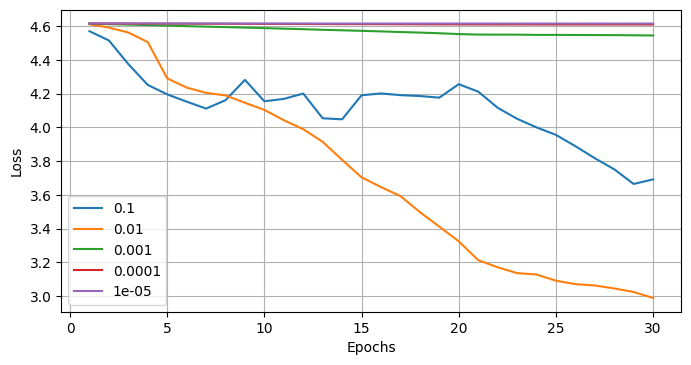

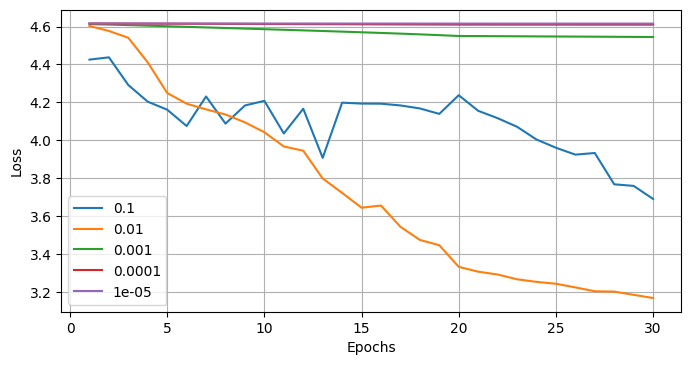

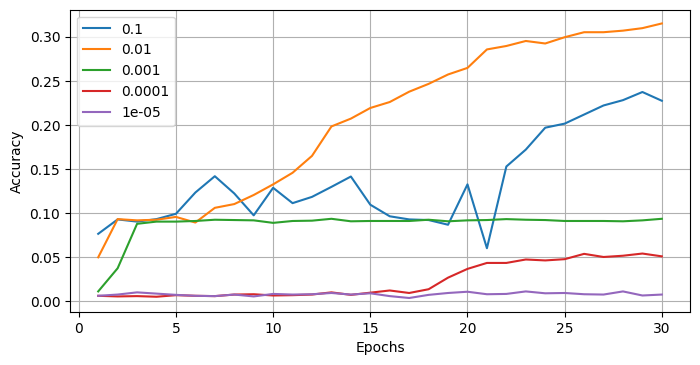

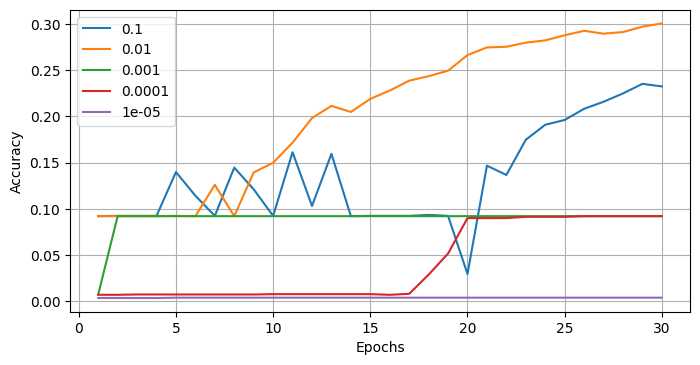

In [ ]:
# Plot loss over epochs
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_TUNING_GRID, logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

# Plot accuracy over epochs
for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_TUNING_GRID, logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

In [ ]:
# We set the optimized learning rate for training
LR = 0.01

### Decaying policy tuning




In [ ]:
STEP_SIZE_GRID = [10, 15, 20]   # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA_GRID = [0.05, 0.1, 0.2]   # Multiplicative factor for learning rate step-down

logs = []

# Perform grid search
for STEP_SIZE in STEP_SIZE_GRID:
    for GAMMA in GAMMA_GRID:
        print(f"Step size: {STEP_SIZE}, Gamma: {GAMMA}")

        net = alexnet()
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # FC layer with NUM_CLASS outputs
        criterion = nn.CrossEntropyLoss()
        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

        tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
        tuning_net.train(NUM_EPOCHS)

        logs.append(tuning_net.get_logs())

Step size: 10, Gamma: 0.05
Starting epoch 1/30, LR = [0.01]
Loss: 4.610152331265536
Validation loss: 4.601125399271647, validation accuracy: 0.09197786998616875

Starting epoch 2/30, LR = [0.01]
Loss: 4.589735984802246
Validation loss: 4.574914773305257, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 3/30, LR = [0.01]
Loss: 4.559415773911909
Validation loss: 4.53603466351827, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 4/30, LR = [0.01]
Loss: 4.479518760334361
Validation loss: 4.322013298670451, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 5/30, LR = [0.01]
Loss: 4.288166436282071
Validation loss: 4.221314748128255, validation accuracy: 0.09232365145228216
Best model updated

Starting epoch 6/30, LR = [0.01]
Loss: 4.219895579598167
Validation loss: 4.1851110855738325, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 7/30, LR = [0.01]
Loss: 4.194910656322133
Validation 

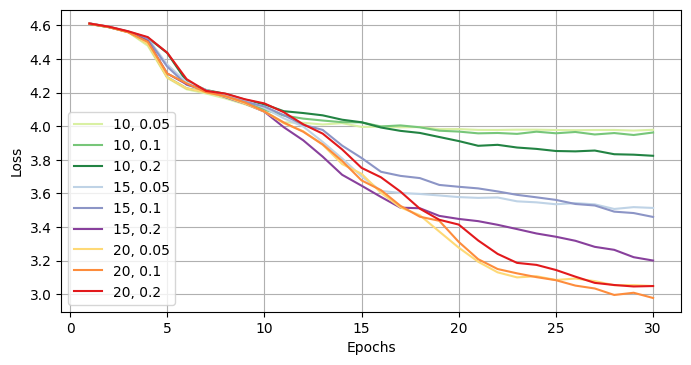

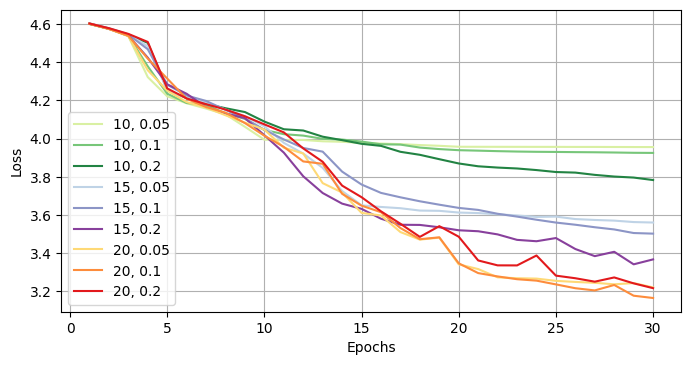

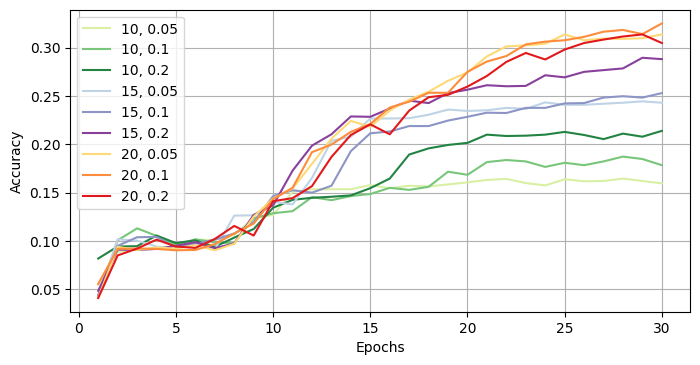

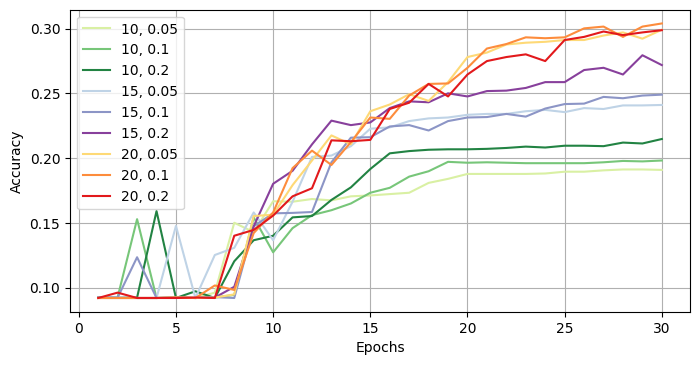

In [ ]:
grid = [(STEP_SIZE, GAMMA) for STEP_SIZE in STEP_SIZE_GRID for GAMMA in GAMMA_GRID]
palette = sns.color_palette("YlGn", 3) + sns.color_palette("BuPu", 3) + sns.color_palette("YlOrRd", 3)

# Plot loss over epochs
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    i = 0
    for step_size in STEP_SIZE_GRID:
        for gamma in GAMMA_GRID:
            ax = sns.lineplot(range(1, len(logs[i][k])+1), logs[i][k], label=f"{step_size}, {gamma}", color=palette[i])
            i +=1

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

# Plot accuracy over epochs
for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    i = 0
    for step_size in STEP_SIZE_GRID:
        for gamma in GAMMA_GRID:
            ax = sns.lineplot(range(1, len(logs[i][k])+1), logs[i][k], label=f"{step_size}, {gamma}", color=palette[i])
            i +=1

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

### Optimized hyper-parameter test

In [ ]:
LR = 0.01
STEP_SIZE = 20
GAMMA = 0.1

net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
tuning_net.train(NUM_EPOCHS)

accuracy = tuning_net.test()

Starting epoch 1/30, LR = [0.01]
Loss: 4.60986176404086
Validation loss: 4.600490093231201, validation accuracy: 0.09232365145228216

Starting epoch 2/30, LR = [0.01]
Loss: 4.590225913307884
Validation loss: 4.574827194213867, validation accuracy: 0.09232365145228216
Best model updated

Starting epoch 3/30, LR = [0.01]
Loss: 4.560238968242299
Validation loss: 4.539545933405559, validation accuracy: 0.16355463347164592
Best model updated

Starting epoch 4/30, LR = [0.01]
Loss: 4.502091581171209
Validation loss: 4.4129921197891235, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 5/30, LR = [0.01]
Loss: 4.307764660228383
Validation loss: 4.277496417363484, validation accuracy: 0.09232365145228216
Best model updated

Starting epoch 6/30, LR = [0.01]
Loss: 4.2424678369001905
Validation loss: 4.22808571656545, validation accuracy: 0.09197786998616875
Best model updated

Starting epoch 7/30, LR = [0.01]
Loss: 4.214487119154497
Validation loss: 4.162780364354451, va

## Transfer learning

### Data preparation

In [ ]:
# Change the Normalize function of Data Preprocessing to Normalize using
# ImageNet's mean and standard deviation
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Prepare Pytorch train/test Datasets
train_full_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indices, val_indices = train_full_dataset.train_validation_split(val_size=VAL_SIZE, random_state=RANDOM_STATE)

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(train_full_dataset, val_indices)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### Hyper-parameter tuning

In [ ]:
# Run experiments with at least three different sets of hyperparameters
# 1. LR (start from lower rate -- see fine-tuning recommendations)
# 2. STEP_SIZE and GAMMA: grid search, same as before
# NUM_EPOCHS: set to 50 and evaluate the difference between 30, 40 and 50 epoch training

NUM_EPOCHS = 50
LR_GRID = [1e-3, 1e-4, 1e-5]    # Smaller learning rates for tuning to avoid drifting too much
STEP_SIZE_GRID = [10, 15, 20]   # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA_GRID = [0.05, 0.1, 0.2]   # Multiplicative factor for learning rate step-down

#### Learning rate tuning

In [ ]:
logs = []

# Default hyper-parameters
STEP_SIZE = 20
GAMMA = 0.1

for LR in LR_GRID:
    print(f"Learning rate: {LR}")

    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
    tuning_net.train(NUM_EPOCHS)

    logs.append(tuning_net.get_logs())

In [ ]:
# Plot loss over epochs
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_GRID, logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

# Plot accuracy over epochs
for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_GRID, logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

In [ ]:
# Set the best learning rate found
LR = 0.001

#### Decaying policy tuning

In [ ]:
STEP_SIZE_GRID = [10, 15, 20]   # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA_GRID = [0.05, 0.1, 0.2]   # Multiplicative factor for learning rate step-down

logs = []

# Perform grid search
for STEP_SIZE in STEP_SIZE_GRID:
    for GAMMA in GAMMA_GRID:
        print(f"Step size: {STEP_SIZE}, Gamma: {GAMMA}")

        net = alexnet(pretrained=True)
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # FC layer with NUM_CLASS outputs
        criterion = nn.CrossEntropyLoss()
        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

        tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
        tuning_net.train(NUM_EPOCHS)

        logs.append(tuning_net.get_logs())

Step size: 10, Gamma: 0.05
Starting epoch 1/50, LR = [0.001]
Loss: 4.024256988005205
Validation loss: 3.1833113630612693, validation accuracy: 0.3188105117565698

Starting epoch 2/50, LR = [0.001]
Loss: 2.778493577783758
Validation loss: 2.3989817102750144, validation accuracy: 0.495850622406639
Best model updated

Starting epoch 3/50, LR = [0.001]
Loss: 1.9674346446990967
Validation loss: 1.7106943527857463, validation accuracy: 0.6109958506224067
Best model updated

Starting epoch 4/50, LR = [0.001]
Loss: 1.2284937555139714
Validation loss: 1.2202375332514446, validation accuracy: 0.7098893499308437
Best model updated

Starting epoch 5/50, LR = [0.001]
Loss: 0.7201717441732233
Validation loss: 0.9677832573652267, validation accuracy: 0.7634854771784232
Best model updated

Starting epoch 6/50, LR = [0.001]
Loss: 0.467062465169213
Validation loss: 0.8618835906187693, validation accuracy: 0.7845781466113416
Best model updated

Starting epoch 7/50, LR = [0.001]
Loss: 0.3225772055712613
V

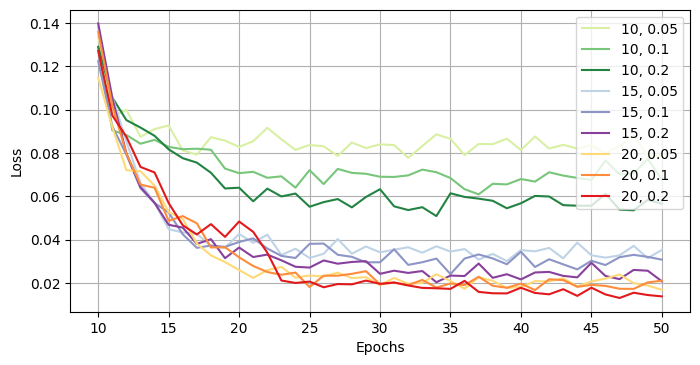

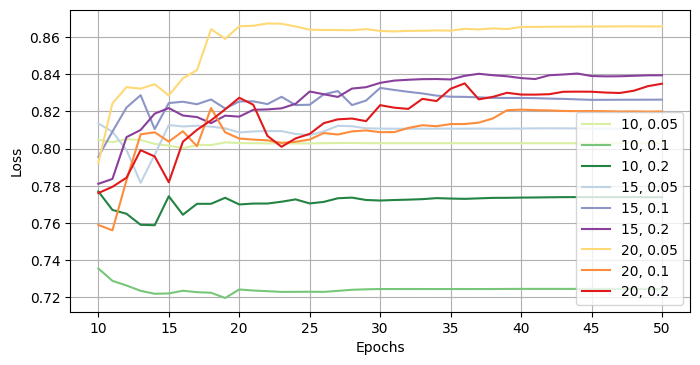

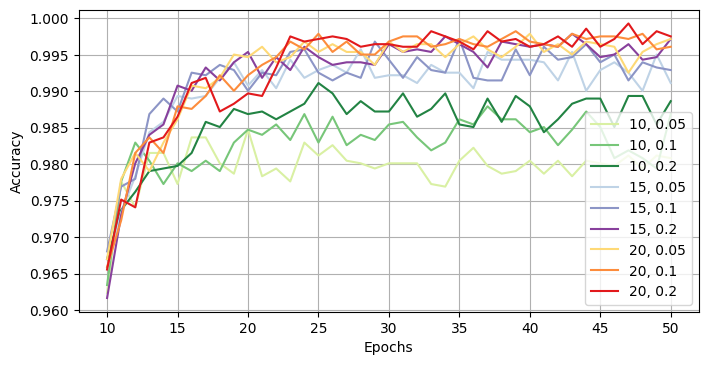

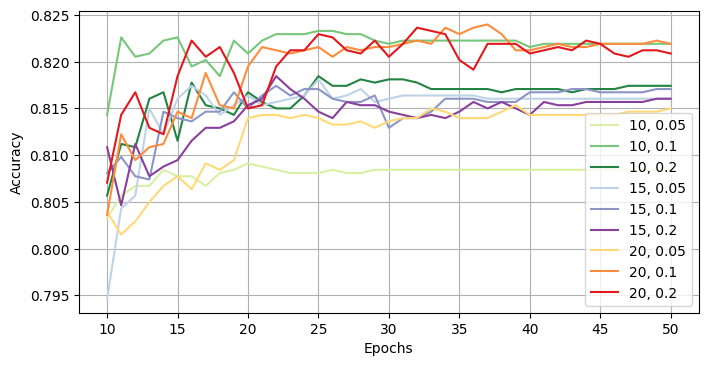

In [ ]:
# NOTE: Plot is cut from 10th epoch to 50th epoch in order to show differences between hyper-parameters

grid = [(STEP_SIZE, GAMMA) for STEP_SIZE in STEP_SIZE_GRID for GAMMA in GAMMA_GRID]
palette = sns.color_palette("YlGn", 3) + sns.color_palette("BuPu", 3) + sns.color_palette("YlOrRd", 3)

# Plot loss over epochs
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    i = 0
    for step_size in STEP_SIZE_GRID:
        for gamma in GAMMA_GRID:
            ax = sns.lineplot(range(10, len(logs[i][k])+1), logs[i][k][9:], label=f"{step_size}, {gamma}", color=palette[i])
            i +=1

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

# Plot accuracy over epochs
for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    i = 0
    for step_size in STEP_SIZE_GRID:
        for gamma in GAMMA_GRID:
            ax = sns.lineplot(range(10, len(logs[i][k])+1), logs[i][k][9:], label=f"{step_size}, {gamma}", color=palette[i])
            i +=1

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

### Network freeze experiments

In [ ]:
# Set the best hyper-parameters obtained
LR = 0.001
STEP_SIZE = 10 # Lowest loss on the validation set, one among the highest accuracies on the validation set
               # (all are very close nonetheless, which suggests the most influential hyperparameter is LR)
GAMMA = 0.1
NUM_EPOCHS = 30 # The models converge around epoch 30

logs = []
test_acc = []

#### Full network

In [ ]:
# Training the whole network with the best hyper-parameters found
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
tuning_net.train(NUM_EPOCHS)

logs.append(tuning_net.get_logs())

test_acc.append(tuning_net.test())

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 4.113504583185369
Validation loss: 3.21323291460673, validation accuracy: 0.30428769017980634

Starting epoch 2/30, LR = [0.001]
Loss: 2.8608982779762964
Validation loss: 2.4832242528597512, validation accuracy: 0.46922544951590595
Best model updated

Starting epoch 3/30, LR = [0.001]
Loss: 2.0408765077590942
Validation loss: 1.7868876854578655, validation accuracy: 0.5982019363762102
Best model updated

Starting epoch 4/30, LR = [0.001]
Loss: 1.305746620351618
Validation loss: 1.2516015370686848, validation accuracy: 0.6936376210235131
Best model updated

Starting epoch 5/30, LR = [0.001]
Loss: 0.7790477817708795
Validation loss: 0.9680723448594412, validation accuracy: 0.7544951590594744
Best model updated

Starting epoch 6/30, LR = [0.001]
Loss: 0.5024710568514738
Validation loss: 0.8618509372075399, validation accuracy: 0.7704011065006916
Best model updated

Starting epoch 7/30, LR = [0.001]
Loss: 0.3370825160633434
Validation loss: 0.8049598087867101, validation accuracy: 0.

#### Fully connected layers

In [ ]:
# Training only the fully connected layers (freeze other layers)
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.classifier.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
tuning_net.train(NUM_EPOCHS)

logs.append(tuning_net.get_logs())

test_acc.append(tuning_net.test())

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 4.144569071856412
Validation loss: 3.2370418707529702, validation accuracy: 0.29771784232365145

Starting epoch 2/30, LR = [0.001]
Loss: 2.8360589417544277
Validation loss: 2.4165064692497253, validation accuracy: 0.4847856154910097
Best model updated

Starting epoch 3/30, LR = [0.001]
Loss: 2.055548299442638
Validation loss: 1.920483022928238, validation accuracy: 0.6099585062240664
Best model updated

Starting epoch 4/30, LR = [0.001]
Loss: 1.5702345046130093
Validation loss: 1.5908779601256053, validation accuracy: 0.671161825726141
Best model updated

Starting epoch 5/30, LR = [0.001]
Loss: 1.2302616834640503
Validation loss: 1.3639649550120037, validation accuracy: 0.7119640387275242
Best model updated

Starting epoch 6/30, LR = [0.001]
Loss: 0.9648250991647894
Validation loss: 1.2038847108681996, validation accuracy: 0.7403181189488244
Best model updated

Starting epoch 7/30, LR = [0.001]
Loss: 0.792005181312561
Validation loss: 1.0847218533356984, validation accuracy: 0.76

#### Convolutional layers

In [ ]:
# Training parameters of the convolutional layers

net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.features.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
tuning_net.train(NUM_EPOCHS)

logs.append(tuning_net.get_logs())

test_acc.append(tuning_net.test())

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 4.89701509475708
Validation loss: 4.698442896207173, validation accuracy: 0.01625172890733057

Starting epoch 2/30, LR = [0.001]
Loss: 4.651292020624334
Validation loss: 4.565933624903361, validation accuracy: 0.042876901798063624
Best model updated

Starting epoch 3/30, LR = [0.001]
Loss: 4.554332256317139
Validation loss: 4.488682270050049, validation accuracy: 0.1078838174273859
Best model updated

Starting epoch 4/30, LR = [0.001]
Loss: 4.471813028508967
Validation loss: 4.404757022857666, validation accuracy: 0.13934993084370678
Best model updated

Starting epoch 5/30, LR = [0.001]
Loss: 4.385974710637873
Validation loss: 4.311837633450826, validation accuracy: 0.15525587828492393
Best model updated

Starting epoch 6/30, LR = [0.001]
Loss: 4.300404635342685
Validation loss: 4.21472704410553, validation accuracy: 0.1884508990318119
Best model updated

Starting epoch 7/30, LR = [0.001]
Loss: 4.2016402157870205
Validation loss: 4.108976662158966, validation accuracy: 0.21127247

#### Convolutional layers and last fully connected layer

In [ ]:
# Training parameters of the convolutional layers + last fc layer

net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = [
    {'params': net.features.parameters()},
    {'params': net.classifier[6].parameters()}
]
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
tuning_net.train(NUM_EPOCHS)

logs.append(tuning_net.get_logs())

test_acc.append(tuning_net.test())

Starting epoch 1/30, LR = [0.001, 0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 4.046807679263028
Validation loss: 3.235033134619395, validation accuracy: 0.2921853388658368

Starting epoch 2/30, LR = [0.001, 0.001]
Loss: 2.880849686535922
Validation loss: 2.5327428778012595, validation accuracy: 0.4654218533886584
Best model updated

Starting epoch 3/30, LR = [0.001, 0.001]
Loss: 2.135515559803356
Validation loss: 1.9284814397494, validation accuracy: 0.5736514522821576
Best model updated

Starting epoch 4/30, LR = [0.001, 0.001]
Loss: 1.4367645220323042
Validation loss: 1.3868529597918193, validation accuracy: 0.6680497925311203
Best model updated

Starting epoch 5/30, LR = [0.001, 0.001]
Loss: 0.905777329748327
Validation loss: 1.0478692203760147, validation accuracy: 0.7344398340248963
Best model updated

Starting epoch 6/30, LR = [0.001, 0.001]
Loss: 0.6034815094687722
Validation loss: 0.9503732323646545, validation accuracy: 0.7486168741355463
Best model updated

Starting epoch 7/30, LR = [0.001, 0.001]
Loss: 0.43552661483938043
Validation loss: 0.8366

#### Comparison

In [ ]:
test_acc

[0.8161078465260975,
 0.8074662979605945,
 0.22779122018665746,
 0.811614241272036]

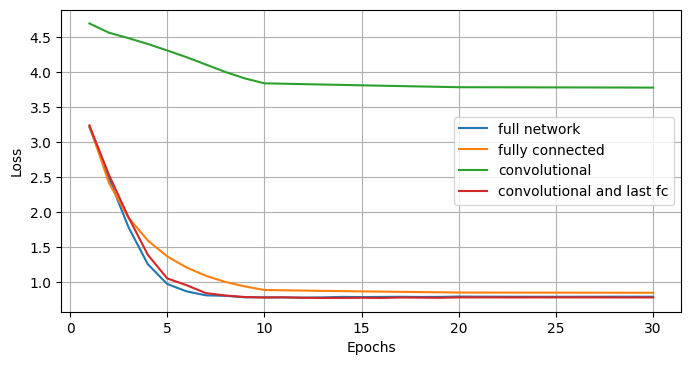

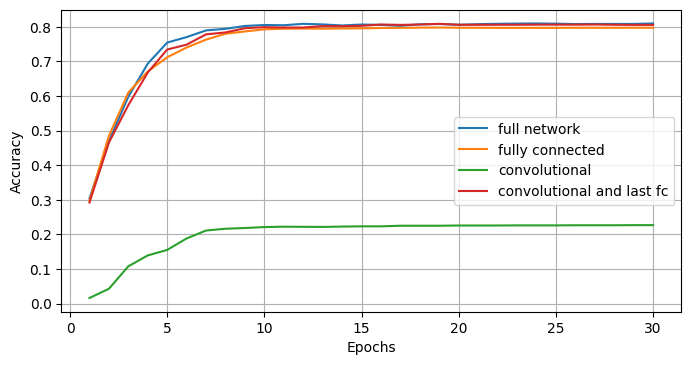

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

for log_i, label in zip(logs, ["full network", "fully connected", "convolutional", "convolutional and last fc"]): # 0: fc, 1: conv
    ax = sns.lineplot(range(1, len(log_i['val_loss'])+1), log_i['val_loss'], label=label)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

for log_i, label in zip(logs, ["full network", "fully connected", "convolutional", "convolutional and last fc"]): # 0: fc, 1: conv
    ax = sns.lineplot(range(1, len(log_i['val_accuracy'])+1), log_i['val_accuracy'], label=label)

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid(True)
plt.show()

## Data augmentation

### Baseline

In [ ]:
# Standard transformations
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Prepare Pytorch train/test Datasets
train_full_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indices, val_indices = train_full_dataset.train_validation_split(val_size=VAL_SIZE, random_state=RANDOM_STATE)

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(train_full_dataset, val_indices)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
# We use the hyper-parameters previously found and apply transfer learning, training the whole network
LR = 0.001 
STEP_SIZE = 10
GAMMA = 0.1
NUM_EPOCHS = 30

net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

baseline_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
baseline_net.train(NUM_EPOCHS)

baseline_logs = baseline_net.get_logs()
baseline_test_acc = baseline_net.test()

### Data preparation

In [ ]:
# We apply three different sets of preprocessing for training images
train_transforms = [
    transforms.Compose([transforms.Resize(256),
                        transforms.CenterCrop(224),

                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                        transforms.RandomHorizontalFlip(p=0.5),

                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    transforms.Compose([transforms.Resize(256),
                        transforms.RandomCrop(224),

                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                        transforms.RandomHorizontalFlip(p=0.5),

                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    transforms.Compose([transforms.Resize(256),
                        transforms.RandomCrop(224),

                        transforms.Grayscale(3),
                        transforms.RandomHorizontalFlip(p=0.5),

                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
]

eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Prepare Pytorch train/test Datasets
train_full_dataset = [Caltech(DATA_DIR, split='train', transform=train_transforms[i]) for i in range(len(train_transforms))]
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indices, val_indices = train_full_dataset[0].train_validation_split(val_size=VAL_SIZE, random_state=RANDOM_STATE)

train_dataset = [Subset(train_full_dataset_i, train_indices) for train_full_dataset_i in train_full_dataset]
val_dataset = [Subset(train_full_dataset_i, val_indices) for train_full_dataset_i in train_full_dataset]

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = [DataLoader(train_dataset_i, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True) for train_dataset_i in train_dataset]
val_dataloader = [DataLoader(val_dataset_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=4) for val_dataset_i in val_dataset]

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


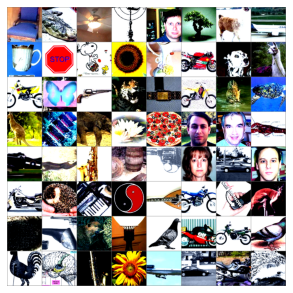

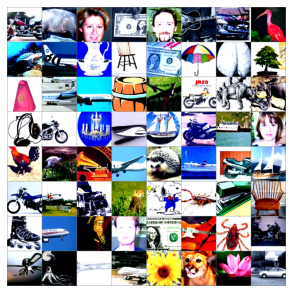

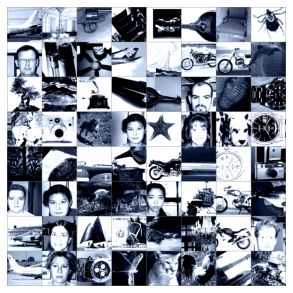

In [ ]:
# Image grids to visualize the three sets of transformations

for i in range(len(train_dataloader)):
    dataiter = iter(train_dataloader[i])
    images, labels = dataiter.next()

    image_grid(images[:64], one_channel=False)

### Network training

In [ ]:
logs = []
test_accuracy = []

for i in range(len(train_dataloader)):
    net = alexnet(pretrained=True)
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.classifier.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    tuning_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader[i], val_dataloader[i], test_dataloader)
    tuning_net.train(NUM_EPOCHS)

    logs.append(tuning_net.get_logs())

    accuracy = tuning_net.test()
    test_accuracy.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Loss: 4.071013537320224
Validation loss: 3.213605006535848, validation accuracy: 0.29322268326417705

Starting epoch 2/30, LR = [0.001]
Loss: 2.8140681223435835
Validation loss: 2.3914957841237388, validation accuracy: 0.49239280774550487
Best model updated

Starting epoch 3/30, LR = [0.001]
Loss: 2.0485157749869605
Validation loss: 1.9116182724634807, validation accuracy: 0.6082295988934993
Best model updated

Starting epoch 4/30, LR = [0.001]
Loss: 1.5778358849612149
Validation loss: 1.576987495024999, validation accuracy: 0.673582295988935
Best model updated

Starting epoch 5/30, LR = [0.001]
Loss: 1.2328287200494246
Validation loss: 1.3514330784479778, validation accuracy: 0.7136929460580913
Best model updated

Starting epoch 6/30, LR = [0.001]
Loss: 0.9897714690728621
Validation loss: 1.1932471891244252, validation accuracy: 0.7444674965421854
Best model updated

Starting epoch 7/30, LR = [0.001]
Loss: 0.8331336216493086
Validation loss: 1.0746049

In [ ]:
print(test_accuracy)
print(baseline_test_acc)

[0.8098859315589354, 0.8078119599032146, 0.7518147251987556]
0.8167991704113378


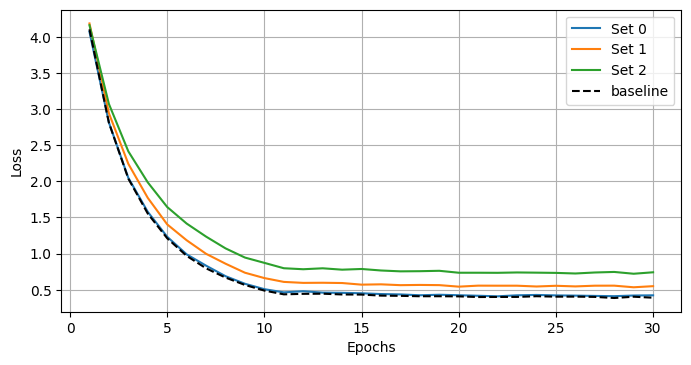

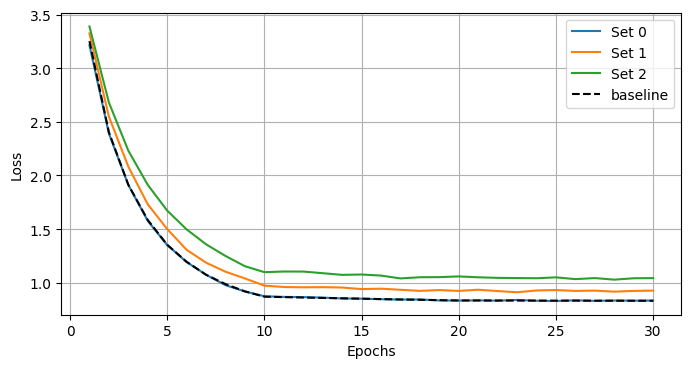

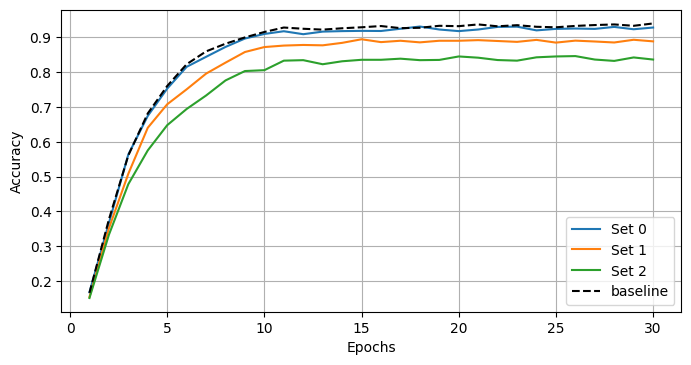

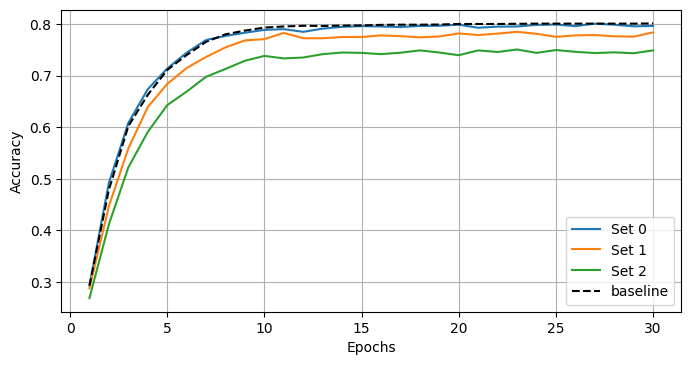

In [ ]:
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    for i, log_i in enumerate(logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=f"Set {i}")
    ax.plot(range(1, len(baseline_logs[k])+1), baseline_logs[k], label='baseline', color='#000000', linestyle='dashed')

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

    for i, log_i in enumerate(logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=f"Set {i}")
    ax.plot(range(1, len(baseline_logs[k])+1), baseline_logs[k], label='baseline', color='#000000', linestyle='dashed')

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

## ResNet implementation

In [ ]:
from torchvision.models import resnet18, resnet34

### Data preparation

In [ ]:
# We use the standard transformations as data augmentation did not improve the model
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Prepare Pytorch train/test Datasets
train_full_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indices, val_indices = train_full_dataset.train_validation_split(val_size=VAL_SIZE, random_state=RANDOM_STATE)

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(train_full_dataset, val_indices)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### AlexNet baseline

In [ ]:
# We use the hyper-parameters previously found and use transfer learning
LR = 0.001 
STEP_SIZE = 10
GAMMA = 0.1
NUM_EPOCHS = 30

net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

baseline_net = NetworkManager(DEVICE, net, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)
baseline_net.train(NUM_EPOCHS)

baseline_logs = baseline_net.get_logs()
baseline_test_acc = baseline_net.test()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/30, LR = [0.001]
Loss: 4.122296268289739
Validation loss: 3.240214983622233, validation accuracy: 0.28769017980636236

Starting epoch 2/30, LR = [0.001]
Loss: 2.858573068271984
Validation loss: 2.487545073032379, validation accuracy: 0.4723374827109267
Best model updated

Starting epoch 3/30, LR = [0.001]
Loss: 2.0767428983341563
Validation loss: 1.8213176826635997, validation accuracy: 0.5912863070539419
Best model updated

Starting epoch 4/30, LR = [0.001]
Loss: 1.3488515181974932
Validation loss: 1.2868444720904033, validation accuracy: 0.6950207468879668
Best model updated

Starting epoch 5/30, LR = [0.001]
Loss: 0.8195084875280206
Validation loss: 0.9793232927719752, validation accuracy: 0.7586445366528354
Best model updated

Starting epoch 6/30, LR = [0.001]
Loss: 0.4848176457665183
Validation loss: 0.8645276973644892, validation accuracy: 0.7825034578146611
Best model updated

Starting epoch 7/30, LR = [0.001]
Loss: 0.3570827272805301
Validation loss: 0.7840079

In [ ]:
print(baseline_logs)
print(baseline_test_acc)

{'train_loss': [4.122296268289739, 2.858573068271984, 2.0767428983341563, 1.3488515181974932, 0.8195084875280206, 0.4848176457665183, 0.3570827272805301, 0.23277243294499136, 0.16993699155070566, 0.13010969012975693, 0.09723603319038045, 0.09465363960374486, 0.09895729883150621, 0.08441623909906908, 0.08888097209009257, 0.07742544602264058, 0.08182839981534264, 0.08298688720573079, 0.08015726134181023, 0.07994786480611021, 0.08019168810410933, 0.07628161494027484, 0.07706550102342259, 0.07583960450508377, 0.07063235003839839, 0.07051198082891377, 0.06720378724011508, 0.07285525412722067, 0.080303605645895, 0.07359056885946881], 'train_accuracy': [0.17009943181818182, 0.37464488636363635, 0.5362215909090909, 0.6818181818181818, 0.7926136363636364, 0.8693181818181818, 0.9002130681818182, 0.9367897727272727, 0.9527698863636364, 0.9641335227272727, 0.9744318181818182, 0.9776278409090909, 0.9751420454545454, 0.9822443181818182, 0.9797585227272727, 0.9825994318181818, 0.9790482954545454, 0.9

In [ ]:
baseline_logs = {'train_loss': [4.122296268289739, 2.858573068271984, 2.0767428983341563, 1.3488515181974932, 0.8195084875280206, 0.4848176457665183, 0.3570827272805301, 0.23277243294499136, 0.16993699155070566, 0.13010969012975693, 0.09723603319038045, 0.09465363960374486, 0.09895729883150621, 0.08441623909906908, 0.08888097209009257, 0.07742544602264058, 0.08182839981534264, 0.08298688720573079, 0.08015726134181023, 0.07994786480611021, 0.08019168810410933, 0.07628161494027484, 0.07706550102342259, 0.07583960450508377, 0.07063235003839839, 0.07051198082891377, 0.06720378724011508, 0.07285525412722067, 0.080303605645895, 0.07359056885946881], 'train_accuracy': [0.17009943181818182, 0.37464488636363635, 0.5362215909090909, 0.6818181818181818, 0.7926136363636364, 0.8693181818181818, 0.9002130681818182, 0.9367897727272727, 0.9527698863636364, 0.9641335227272727, 0.9744318181818182, 0.9776278409090909, 0.9751420454545454, 0.9822443181818182, 0.9797585227272727, 0.9825994318181818, 0.9790482954545454, 0.9779829545454546, 0.9801136363636364, 0.9769176136363636, 0.9811789772727273, 0.9825994318181818, 0.9811789772727273, 0.9808238636363636, 0.9868607954545454, 0.984375, 0.9868607954545454, 0.9847301136363636, 0.9818892045454546, 0.9836647727272727], 'val_loss': [3.240214983622233, 2.487545073032379, 1.8213176826635997, 1.2868444720904033, 0.9793232927719752, 0.8645276973644892, 0.7840079168478647, 0.7778722991545995, 0.7987670103708903, 0.8039206862449646, 0.7800090461969376, 0.7723385443290075, 0.7748706340789795, 0.7697754253943762, 0.7673432181278864, 0.7689210524161657, 0.769782563050588, 0.7707932690779368, 0.773162399729093, 0.7675745636224747, 0.7677454153696696, 0.7681922813256582, 0.768469492594401, 0.768784741560618, 0.7692188521226248, 0.7697958548863729, 0.7701792369286219, 0.7702694684267044, 0.7699685047070185, 0.7703892439603806], 'val_accuracy': [0.28769017980636236, 0.4723374827109267, 0.5912863070539419, 0.6950207468879668, 0.7586445366528354, 0.7825034578146611, 0.7949515905947441, 0.8022130013831259, 0.8001383125864454, 0.8008298755186722, 0.8084370677731674, 0.8091286307053942, 0.8094744121715076, 0.808091286307054, 0.8087828492392808, 0.8091286307053942, 0.8091286307053942, 0.8105117565698479, 0.8091286307053942, 0.8108575380359613, 0.8108575380359613, 0.8101659751037344, 0.809820193637621, 0.8108575380359613, 0.8112033195020747, 0.8118948824343015, 0.8108575380359613, 0.8108575380359613, 0.8108575380359613, 0.8108575380359613]}
baseline_test_acc = 0.8192188040096785

### ResNet-18

In [ ]:
BATCH_SIZE = 64 # Decrease batch size to 64 as larger models consume more GPU memory
NUM_EPOCHS = 30

In [ ]:
LR_GRID = [1e-1, 1e-2, 1e-3, 1e-4]
STEP_SIZE = 20
GAMMA = 0.1

In [ ]:
resnet18_logs = []
resnet18_test_acc = []

for LR in LR_GRID:
    # Pretrained version of ResNet-18
    rn18 = resnet18(pretrained=True)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Transfer learning
    fc_in = rn18.fc.in_features
    fc_out = NUM_CLASSES
    rn18.fc = nn.Linear(fc_in, fc_out)
    parameters_to_optimize = rn18.parameters()

    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    rn18_net = NetworkManager(DEVICE, rn18, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)

    rn18_net.train(NUM_EPOCHS)

    accuracy = rn18_net.test()

    # Logging
    resnet18_logs.append(rn18_net.get_logs())
    resnet18_test_acc.append(accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Starting epoch 1/30, LR = [0.1]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 5.704550160302056
Validation loss: 3535.643899668818, validation accuracy: 0.004495159059474412

Starting epoch 2/30, LR = [0.1]
Loss: 4.90531817012363
Validation loss: 4.968799642894579, validation accuracy: 0.10027662517289074
Best model updated

Starting epoch 3/30, LR = [0.1]
Loss: 3.997726562288072
Validation loss: 3.833275644675545, validation accuracy: 0.17600276625172892
Best model updated

Starting epoch 4/30, LR = [0.1]
Loss: 3.756075700124105
Validation loss: 3.784792625385782, validation accuracy: 0.1970954356846473
Best model updated

Starting epoch 5/30, LR = [0.1]
Loss: 3.6484233008490667
Validation loss: 3.6657732673313306, validation accuracy: 0.24619640387275243
Best model updated

Starting epoch 6/30, LR = [0.1]
Loss: 3.4957951916588677
Validation loss: 3.4526304628538047, validation accuracy: 0.2714384508990318
Best model updated

Starting epoch 7/30, LR = [0.1]
Loss: 3.3422714657253687
Validation loss: 3.3551988705344824, validation accuracy: 0.29875518672199

In [ ]:
print(resnet18_logs)
print(resnet18_test_acc)

[{'train_loss': [5.704550160302056, 4.90531817012363, 3.997726562288072, 3.756075700124105, 3.6484233008490667, 3.4957951916588677, 3.3422714657253687, 3.2017351362440323, 3.0159904321034747, 2.843124765819973, 2.6793682204352485, 2.566373274061415, 2.4779466999901665, 2.3145827425850762, 2.126388226615058, 2.0152858999040393, 1.8511807998021443, 1.787489684422811, 1.5554083824157714, 1.3644714328977796, 0.9625217967563205, 0.6896333972613017, 0.604684317111969, 0.5477631986141205, 0.48216892745759754, 0.4438228560818566, 0.4045467413134045, 0.3592020471890767, 0.3249334315458933, 0.29788433545165593], 'train_accuracy': [0.18958333333333333, 0.115625, 0.15833333333333333, 0.19479166666666667, 0.234375, 0.2586805555555556, 0.284375, 0.3017361111111111, 0.3260416666666667, 0.3416666666666667, 0.3767361111111111, 0.4013888888888889, 0.409375, 0.45, 0.471875, 0.4965277777777778, 0.5298611111111111, 0.5430555555555555, 0.5885416666666666, 0.640625, 0.7454861111111111, 0.8211805555555556, 0.

In [ ]:
resnet18_logs = [{'train_loss': [5.704550160302056, 4.90531817012363, 3.997726562288072, 3.756075700124105, 3.6484233008490667, 3.4957951916588677, 3.3422714657253687, 3.2017351362440323, 3.0159904321034747, 2.843124765819973, 2.6793682204352485, 2.566373274061415, 2.4779466999901665, 2.3145827425850762, 2.126388226615058, 2.0152858999040393, 1.8511807998021443, 1.787489684422811, 1.5554083824157714, 1.3644714328977796, 0.9625217967563205, 0.6896333972613017, 0.604684317111969, 0.5477631986141205, 0.48216892745759754, 0.4438228560818566, 0.4045467413134045, 0.3592020471890767, 0.3249334315458933, 0.29788433545165593], 'train_accuracy': [0.18958333333333333, 0.115625, 0.15833333333333333, 0.19479166666666667, 0.234375, 0.2586805555555556, 0.284375, 0.3017361111111111, 0.3260416666666667, 0.3416666666666667, 0.3767361111111111, 0.4013888888888889, 0.409375, 0.45, 0.471875, 0.4965277777777778, 0.5298611111111111, 0.5430555555555555, 0.5885416666666666, 0.640625, 0.7454861111111111, 0.8211805555555556, 0.8475694444444445, 0.8621527777777778, 0.8791666666666667, 0.8965277777777778, 0.9048611111111111, 0.9267361111111111, 0.9378472222222223, 0.9420138888888889], 'val_loss': [3535.643899668818, 4.968799642894579, 3.833275644675545, 3.784792625385782, 3.6657732673313306, 3.4526304628538047, 3.3551988705344824, 3.1976905180060347, 3.1445639185283496, 3.01406935505245, 2.917988875637884, 3.0305847758832187, 2.8564362370449565, 2.98599258194799, 2.682987627775773, 2.646527912305749, 2.627168702042621, 2.585363209247589, 2.6044977514640144, 2.747789600621099, 2.2037961068360703, 2.2656126540640127, 2.259459262308867, 2.2673339895580127, 2.2542586533919624, 2.250407866809679, 2.2408195086147473, 2.2774835228919983, 2.308266152506289, 2.286786400753519], 'val_accuracy': [0.004495159059474412, 0.10027662517289074, 0.17600276625172892, 0.1970954356846473, 0.24619640387275243, 0.2714384508990318, 0.2987551867219917, 0.31293222683264177, 0.32503457814661135, 0.34681881051175656, 0.37136929460580914, 0.3551175656984786, 0.39315352697095435, 0.35408022130013833, 0.41009681881051174, 0.42531120331950206, 0.4339557399723375, 0.44951590594744123, 0.4578146611341632, 0.4464038727524205, 0.5217842323651453, 0.5221300138312587, 0.5280082987551867, 0.530774550484094, 0.5352697095435685, 0.5373443983402489, 0.5418395573997233, 0.5401106500691563, 0.5366528354080221, 0.5442600276625172]}, {'train_loss': [2.499115612771776, 0.5065261248085234, 0.1330746923883756, 0.05418285528818766, 0.028691216309865316, 0.019481557607650756, 0.014178183343675401, 0.010888834959930843, 0.009433279103702969, 0.008273453844918146, 0.0071939736604690555, 0.006590490871005588, 0.005719396471977234, 0.0055134269926283095, 0.004752656155162387, 0.004845604631635878, 0.004091313481330872, 0.00395049684577518, 0.0037609421544604832, 0.00353680153687795, 0.003552013635635376, 0.003363224201732212, 0.003340485692024231, 0.003325444459915161, 0.003324837154812283, 0.0033188141054577296, 0.0033306380112965903, 0.0032677339182959663, 0.0034159743123584325, 0.003466028306219313], 'train_accuracy': [0.47465277777777776, 0.9125, 0.9840277777777777, 0.9965277777777778, 0.9989583333333333, 0.9993055555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [1.136042497728182, 0.49898731384588324, 0.3870750756367393, 0.3700539664081905, 0.3275740042976711, 0.32320432170577673, 0.30674400115790573, 0.3028500008842219, 0.2986805069705714, 0.2957365101446276, 0.2920846916411234, 0.2923379326644151, 0.29509338266823604, 0.2908702450601951, 0.28593866300323734, 0.28566819429397583, 0.2850029845924481, 0.2851074339578981, 0.28375291435614874, 0.2810314707458019, 0.2811107803945956, 0.2827853920019191, 0.2807875439200712, 0.2787572875942873, 0.2837014710125716, 0.28014859864893166, 0.2838766620210979, 0.280903904820266, 0.2814284804398599, 0.2823422523620336], 'val_accuracy': [0.75, 0.8855463347164592, 0.9100968188105117, 0.9135546334716459, 0.926002766251729, 0.926002766251729, 0.9284232365145229, 0.9304979253112033, 0.9301521438450899, 0.9287690179806363, 0.9304979253112033, 0.9298063623789765, 0.9298063623789765, 0.9304979253112033, 0.931881051175657, 0.931881051175657, 0.9325726141078838, 0.9315352697095436, 0.9308437067773168, 0.9315352697095436, 0.9329183955739973, 0.9311894882434302, 0.9322268326417704, 0.931881051175657, 0.931881051175657, 0.931881051175657, 0.9308437067773168, 0.931881051175657, 0.9336099585062241, 0.9322268326417704]}, {'train_loss': [3.830511220296224, 2.671921984354655, 2.1178842041227552, 1.669895315170288, 1.3075063347816467, 1.0396525237295362, 0.8328361299302843, 0.6714856094784207, 0.5454118351141611, 0.45440265271398755, 0.3793519659174813, 0.31943278974956935, 0.26814733975463445, 0.23379526436328887, 0.20205486665169398, 0.17407375623782476, 0.15505973945061366, 0.1405150145292282, 0.12661883963478937, 0.11194388684299257, 0.10010642343097263, 0.10176255140039656, 0.10163734985722436, 0.09947751131322649, 0.09757733527157042, 0.09776545663674673, 0.09683241777949864, 0.09339953809976578, 0.09262626833385891, 0.09316855437225766], 'train_accuracy': [0.20347222222222222, 0.45069444444444445, 0.6225694444444444, 0.7270833333333333, 0.8027777777777778, 0.8694444444444445, 0.909375, 0.9388888888888889, 0.9583333333333334, 0.9673611111111111, 0.9763888888888889, 0.9840277777777777, 0.9895833333333334, 0.9934027777777777, 0.9944444444444445, 0.9961805555555555, 0.996875, 0.9989583333333333, 0.9986111111111111, 0.9986111111111111, 0.9996527777777777, 0.9996527777777777, 0.9996527777777777, 0.9993055555555556, 0.9996527777777777, 0.9993055555555556, 0.9996527777777777, 0.9996527777777777, 0.9993055555555556, 0.9996527777777777], 'val_loss': [2.983355921247731, 2.424734802349754, 1.9846411839775417, 1.6186414101849431, 1.3672105747720469, 1.1571209767590398, 1.0097107019113458, 0.8866189199945201, 0.7940820313018301, 0.7278797056363977, 0.6834115936704304, 0.640991017870281, 0.5959480450205181, 0.5652681349412255, 0.5394099147423453, 0.5305409949758778, 0.5118774920701981, 0.497297496251438, 0.48193920241749805, 0.47750270755394647, 0.46813437472219055, 0.47065273316010187, 0.47069357205992157, 0.4670171109230622, 0.46660930954891705, 0.46634873618250305, 0.4646688479444255, 0.4628769269456034, 0.4665578182624734, 0.45890309434870014], 'val_accuracy': [0.3412863070539419, 0.5397648686030428, 0.6327800829875518, 0.7026279391424619, 0.7627939142461964, 0.8125864453665284, 0.8405947441217151, 0.8620331950207469, 0.8699861687413555, 0.8838174273858921, 0.8865836791147994, 0.8948824343015215, 0.8983402489626556, 0.9024896265560166, 0.9049100968188105, 0.906984785615491, 0.9087136929460581, 0.9087136929460581, 0.9107883817427386, 0.9125172890733056, 0.9132088520055325, 0.911134163208852, 0.9114799446749654, 0.9128630705394191, 0.9125172890733056, 0.9121715076071922, 0.9121715076071922, 0.9149377593360996, 0.9139004149377593, 0.911134163208852]}, {'train_loss': [4.729845364888509, 4.19692964553833, 3.8259338431888157, 3.5815911346011693, 3.382977490954929, 3.2386792500813804, 3.1249369780222573, 3.0269333998362224, 2.93424645529853, 2.8493567042880588, 2.778316275278727, 2.7099982526567246, 2.642953199810452, 2.568831957711114, 2.5053543567657472, 2.443357886208428, 2.3820555872387357, 2.3243016269471912, 2.2674111816618177, 2.2011733161078557, 2.170785199271308, 2.164191155963474, 2.1562717543707954, 2.154518061214023, 2.146554530991448, 2.1373279889424643, 2.1360609107547335, 2.133972340159946, 2.125692049662272, 2.1224122603734332], 'train_accuracy': [0.019097222222222224, 0.1920138888888889, 0.2326388888888889, 0.23993055555555556, 0.2611111111111111, 0.2920138888888889, 0.321875, 0.3489583333333333, 0.37118055555555557, 0.4013888888888889, 0.4114583333333333, 0.43680555555555556, 0.45694444444444443, 0.4809027777777778, 0.5024305555555556, 0.5194444444444445, 0.54375, 0.559375, 0.5795138888888889, 0.6038194444444445, 0.6065972222222222, 0.6121527777777778, 0.6211805555555555, 0.6197916666666666, 0.6197916666666666, 0.6246527777777777, 0.6215277777777778, 0.6177083333333333, 0.6201388888888889, 0.6239583333333333], 'val_loss': [4.454865134280661, 4.001428738884304, 3.7138161296429844, 3.4957350492477417, 3.338634765666464, 3.2152033318643984, 3.1183006089666616, 3.0315263426822163, 2.957011886264967, 2.8813404207644253, 2.8183520203051358, 2.752825721450474, 2.687548176102016, 2.6327413009560625, 2.5733179424120034, 2.519423756910407, 2.465609451998835, 2.4138654107632846, 2.3634630519410837, 2.3123883579088296, 2.307132943816807, 2.3013485074043274, 2.295648673306341, 2.2923093282658122, 2.284765764423039, 2.2871042982391687, 2.281334773353908, 2.2672030951665794, 2.2636965020843176, 2.2581359329430954], 'val_accuracy': [0.10615491009681881, 0.2268326417704011, 0.2354771784232365, 0.24204702627939143, 0.2714384508990318, 0.30463347164591975, 0.3354080221300138, 0.3516597510373444, 0.3724066390041494, 0.3893499308437068, 0.40767634854771784, 0.42773167358229597, 0.4432918395573997, 0.4598893499308437, 0.47648686030428766, 0.4951590594744122, 0.5131396957123098, 0.5276625172890733, 0.5439142461964038, 0.5594744121715076, 0.5667358229598893, 0.5674273858921162, 0.5677731673582296, 0.5691562932226832, 0.5733056708160442, 0.5719225449515906, 0.5695020746887967, 0.5733056708160442, 0.5767634854771784, 0.5750345781466113]}]
resnet18_test_acc = [0.538195644659523, 0.9305219495333564, 0.9153128240580712, 0.5765641202903561]

In [ ]:
# Plot loss over epochs
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_GRID, resnet18_logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.plot(range(1, len(baseline_logs[k])+1), baseline_logs[k], label='baseline', color='#000000', linestyle='dashed')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

# Plot accuracy over epochs
for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_GRID, resnet18_logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.plot(range(1, len(baseline_logs[k])+1), baseline_logs[k], label='baseline', color='#000000', linestyle='dashed')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

### ResNet-34

In [ ]:
BATCH_SIZE = 64

resnet34_logs = []
resnet34_test_acc = []

for LR in LR_GRID:
    # Pretrained version of ResNet-34
    rn34 = resnet34(pretrained=True)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Transfer learning
    fc_in = rn34.fc.in_features
    fc_out = NUM_CLASSES
    rn34.fc = nn.Linear(fc_in, fc_out)
    parameters_to_optimize = rn34.parameters()

    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    rn34_net = NetworkManager(DEVICE, rn34, criterion, optimizer, scheduler, train_dataloader, val_dataloader, test_dataloader)

    rn34_net.train(NUM_EPOCHS)

    accuracy = rn34_net.test()

    # Logging
    resnet34_logs.append(rn34_net.get_logs())
    resnet34_test_acc.append(accuracy)

Starting epoch 1/30, LR = [0.1]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 5.811931382285224
Validation loss: 281100.15166440216, validation accuracy: 0.09232365145228216

Starting epoch 2/30, LR = [0.1]
Loss: 4.593249225616455
Validation loss: 5.096089497856472, validation accuracy: 0.10096818810511757
Best model updated

Starting epoch 3/30, LR = [0.1]
Loss: 4.228767193688286
Validation loss: 4.165922050890715, validation accuracy: 0.11618257261410789
Best model updated

Starting epoch 4/30, LR = [0.1]
Loss: 4.164606396357218
Validation loss: 4.152384193047233, validation accuracy: 0.11929460580912864
Best model updated

Starting epoch 5/30, LR = [0.1]
Loss: 4.136951674355401
Validation loss: 4.185983994732732, validation accuracy: 0.12448132780082988

Starting epoch 6/30, LR = [0.1]
Loss: 4.105056646135118
Validation loss: 4.2105245693870215, validation accuracy: 0.12828492392807744

Starting epoch 7/30, LR = [0.1]
Loss: 4.014198573430379
Validation loss: 4.147515151811683, validation accuracy: 0.1441908713692946
Best model updated

Starting epoch 8/

In [ ]:
print(resnet34_logs)
print(resnet34_test_acc)

[{'train_loss': [5.811931382285224, 4.593249225616455, 4.228767193688286, 4.164606396357218, 4.136951674355401, 4.105056646135118, 4.014198573430379, 3.8412256399790445, 3.7051037311553956, 3.562092489666409, 3.423492839601305, 3.3073690626356336, 3.1585594283209906, 2.992384974161784, 2.840986140569051, 2.735744508107503, 2.6185045851601494, 2.546427541308933, 2.3593029816945394, 2.21888554626041, 1.8976209137174818, 1.7051079008314345, 1.6274946080313788, 1.5457052840126886, 1.486092660162184, 1.4185089455710518, 1.3336066007614136, 1.285054580370585, 1.2020318984985352, 1.0924205316437616], 'train_accuracy': [0.19791666666666666, 0.09861111111111111, 0.0920138888888889, 0.103125, 0.11041666666666666, 0.12013888888888889, 0.16319444444444445, 0.18055555555555555, 0.2013888888888889, 0.2222222222222222, 0.2517361111111111, 0.26805555555555555, 0.296875, 0.32013888888888886, 0.3416666666666667, 0.35868055555555556, 0.3836805555555556, 0.39166666666666666, 0.43645833333333334, 0.46875, 

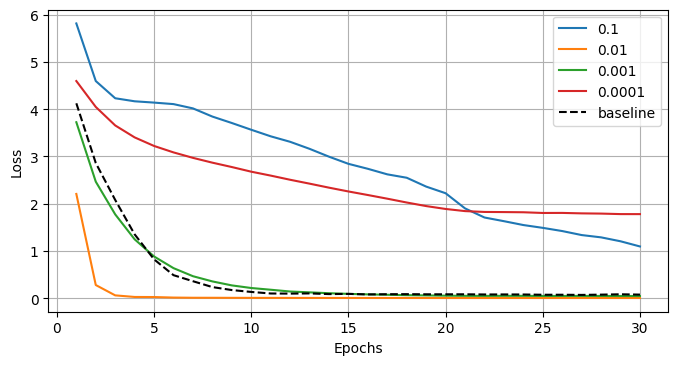

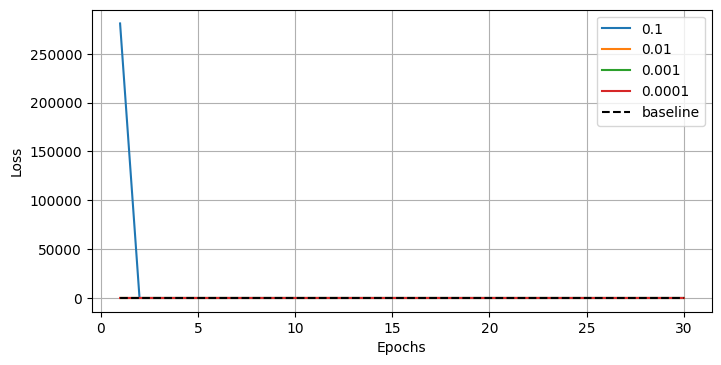

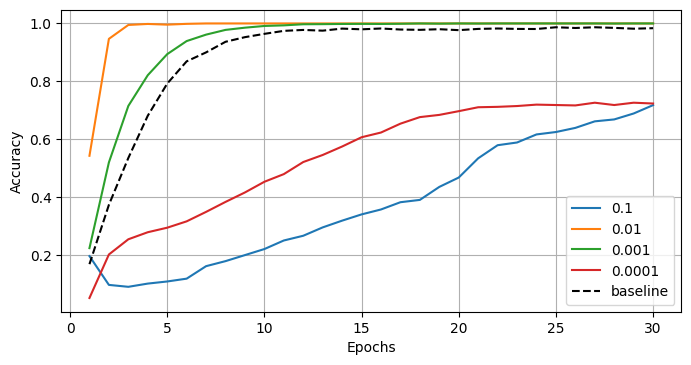

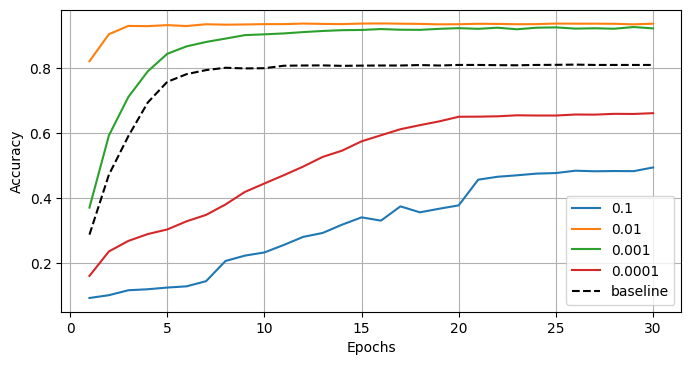

In [ ]:
# Plot loss over epochs
for k in ['train_loss', 'val_loss']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_GRID, resnet34_logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.plot(range(1, len(baseline_logs[k])+1), baseline_logs[k], label='baseline', color='#000000', linestyle='dashed')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

# Plot accuracy over epochs
for k in ['train_accuracy', 'val_accuracy']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    for lr, log_i in zip(LR_GRID, resnet34_logs):
        ax = sns.lineplot(range(1, len(log_i[k])+1), log_i[k], label=lr)
    ax.plot(range(1, len(baseline_logs[k])+1), baseline_logs[k], label='baseline', color='#000000', linestyle='dashed')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plt.show()

### Comparison

In [ ]:
# ResNet-18: best LR = 0.01
# ResNet-34: best LR = 0.01

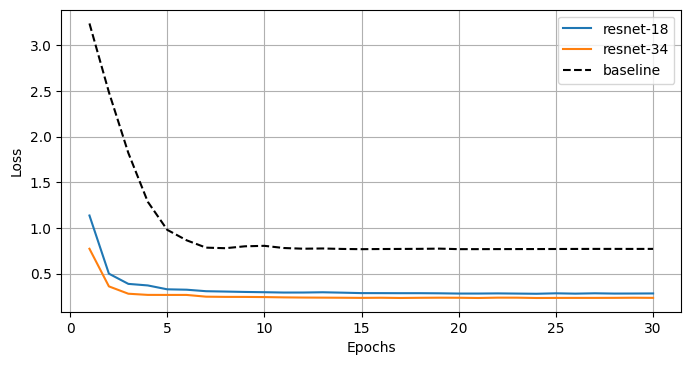

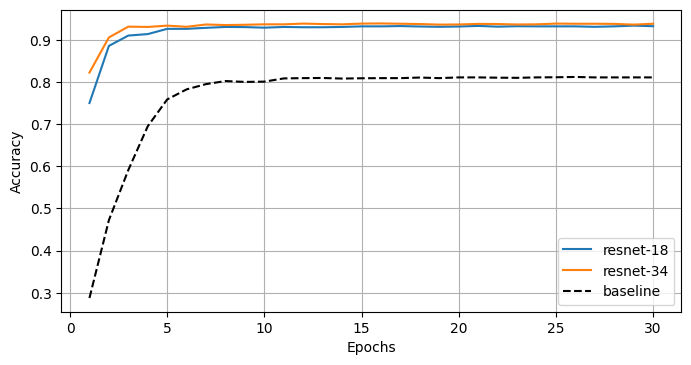

In [ ]:
# Plot loss over epochs for best models
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax = sns.lineplot(range(1, len(resnet18_logs[1]['val_loss'])+1), resnet18_logs[1]['val_loss'], label='resnet-18')
ax = sns.lineplot(range(1, len(resnet34_logs[1]['val_loss'])+1), resnet34_logs[1]['val_loss'], label='resnet-34')
ax.plot(range(1, len(baseline_logs['val_loss'])+1), baseline_logs['val_loss'], label='baseline', color='#000000', linestyle='dashed')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)
plt.show()

# Plot accuracy over epochs for best models
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax = sns.lineplot(range(1, len(resnet18_logs[1]['val_accuracy'])+1), resnet18_logs[1]['val_accuracy'], label='resnet-18')
ax = sns.lineplot(range(1, len(resnet34_logs[1]['val_accuracy'])+1), resnet34_logs[1]['val_accuracy'], label='resnet-34')
ax.plot(range(1, len(baseline_logs['val_accuracy'])+1), baseline_logs['val_accuracy'], label='baseline', color='#000000', linestyle='dashed')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid(True)
plt.show()